In [2]:
import pandas as pd
import numpy as np
import nltk
import jieba
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Basic text cleaning and tokenization with Jieba
def preprocess_text(text):
    text = str(text)
    # Tokenization with Jieba
    tokens = list(jieba.cut(text))
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [5]:
# Replace NaN values with an empty string
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

# Apply preprocessing
df_train['tokens'] = df_train['text'].apply(preprocess_text)
df_test['tokens'] = df_test['text'].apply(preprocess_text)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.703 seconds.
DEBUG:jieba:Loading model cost 0.703 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [6]:
# Concatenate tokens for Word2Vec training
all_tokens = pd.concat([df_train['tokens'], df_test['tokens']], axis=0)

# Train a Word2Vec model or load a pre-trained model
model_w2v = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [7]:
# Function to convert tokens to vectors, using zero vector for unknown words
def tokens_to_vectors(tokens, model):
    vectors = [model.wv[word] if word in model.wv else np.zeros((model.vector_size,)) for word in tokens]
    return np.array(vectors)

In [8]:
# Convert train and test tokens to vectors
df_train['vectors'] = df_train['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))
df_test['vectors'] = df_test['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))

In [9]:
# Find the maximum sequence length to use for padding
max_seq_length = max(df_train['vectors'].apply(len).max(), df_test['vectors'].apply(len).max())

In [10]:
# Pad sequences
X_train_padded = pad_sequences(df_train['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')
X_test_padded = pad_sequences(df_test['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')

In [11]:
# Convert sentiment labels to numerical values
label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
df_train['label'] = df_train['sentiment'].map(label_mapping)
y_train = df_train['label'].values

In [12]:
# Split dataset into training, validation, and test sets
X_train_padded, X_temp, y_train, y_temp = train_test_split(X_train_padded, y_train, test_size=0.4, random_state=42)
X_val_padded, X_test_padded, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [16]:
# Define the model architecture
embedding_dim = model_w2v.vector_size
input_layer = Input(shape=(max_seq_length, embedding_dim))
attention_out = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, value_dim=embedding_dim)(query=input_layer, key=input_layer, value=input_layer)

# TextCNN
conv1 = Conv1D(filters=100, kernel_size=3, activation='relu')(attention_out)
conv2 = Conv1D(filters=100, kernel_size=4, activation='relu')(attention_out)
conv3 = Conv1D(filters=100, kernel_size=5, activation='relu')(attention_out)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

concatenated = Concatenate()([pool1, pool2, pool3])

# Apply Dropout for regularization
dropout_rate = 0.5
dropout_layer = Dropout(rate=dropout_rate)(concatenated)

# Fully connected layer with batch normalization
dense_units = 256
dense_layer = Dense(units=dense_units, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer)
batch_norm_layer = BatchNormalization()(dense_layer)

# Output layer
output_layer = Dense(units=3, activation='softmax')(batch_norm_layer)

# Define and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_data=(X_val_padded, y_val))

Epoch 1/50
516/516 [==============================] - 8s 11ms/step - loss: 1.7481 - accuracy: 0.4347 - val_loss: 1.2973 - val_accuracy: 0.4205
Epoch 2/50
516/516 [==============================] - 4s 8ms/step - loss: 1.1588 - accuracy: 0.4931 - val_loss: 1.1461 - val_accuracy: 0.4420
Epoch 3/50
516/516 [==============================] - 4s 8ms/step - loss: 1.0607 - accuracy: 0.4999 - val_loss: 1.0625 - val_accuracy: 0.4636
Epoch 4/50
516/516 [==============================] - 5s 9ms/step - loss: 1.0350 - accuracy: 0.5089 - val_loss: 1.0232 - val_accuracy: 0.5166
Epoch 5/50
516/516 [==============================] - 4s 8ms/step - loss: 1.0081 - accuracy: 0.5307 - val_loss: 0.9877 - val_accuracy: 0.5457
Epoch 6/50
516/516 [==============================] - 5s 10ms/step - loss: 0.9822 - accuracy: 0.5513 - val_loss: 0.9564 - val_accuracy: 0.5704
Epoch 7/50
516/516 [==============================] - 4s 9ms/step - loss: 0.9610 - accuracy: 0.5732 - val_loss: 0.9610 - val_accuracy: 0.5741
Epoc

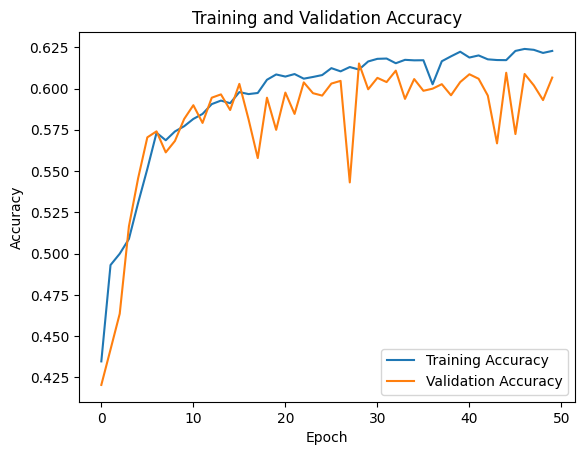

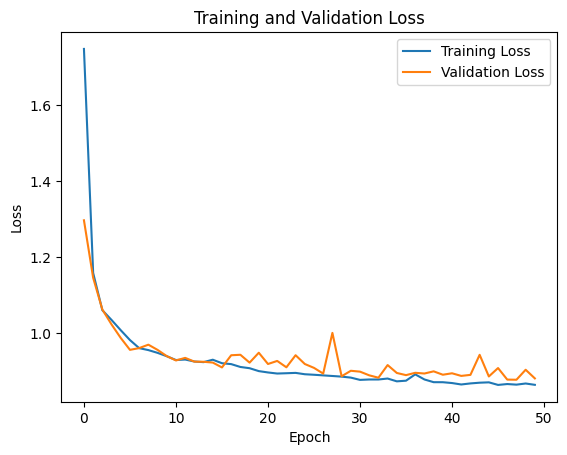

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

172/172 [==============================] - 1s 4ms/step


<Axes: >

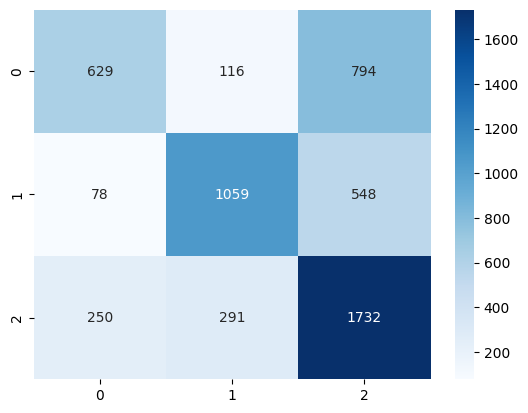

In [18]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test_padded), axis=-1)

# Metrics and Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

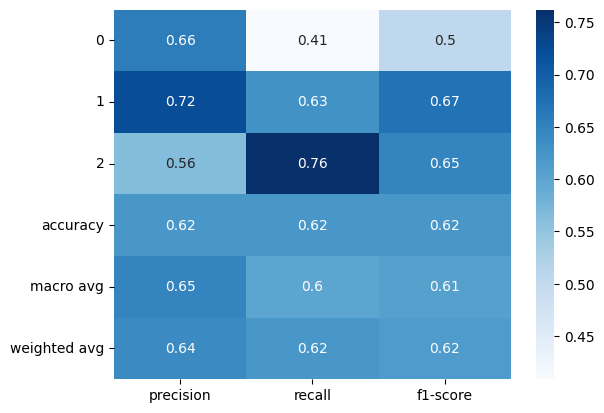

In [19]:
clf_report=classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="Blues")
plt.show()

172/172 [==============================] - 1s 3ms/step
Overall ROC-AUC Score: 0.7799310868692034


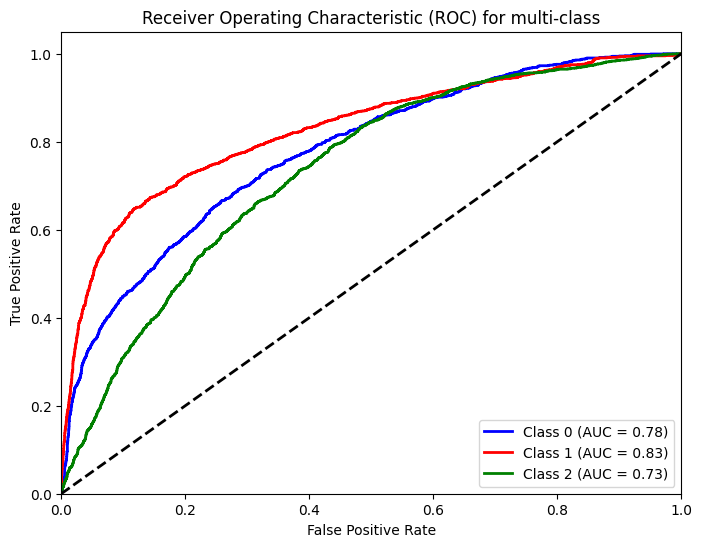

In [33]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Convert y_test to one-hot encoded format if it's not already
if len(y_test.shape) == 1:
    label_binarizer = LabelBinarizer()
    y_test = label_binarizer.fit_transform(y_test)

# Calculate the ROC AUC Score
y_prob = model.predict(X_test_padded)
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"Overall ROC-AUC Score: {roc_auc_ovr}")

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()

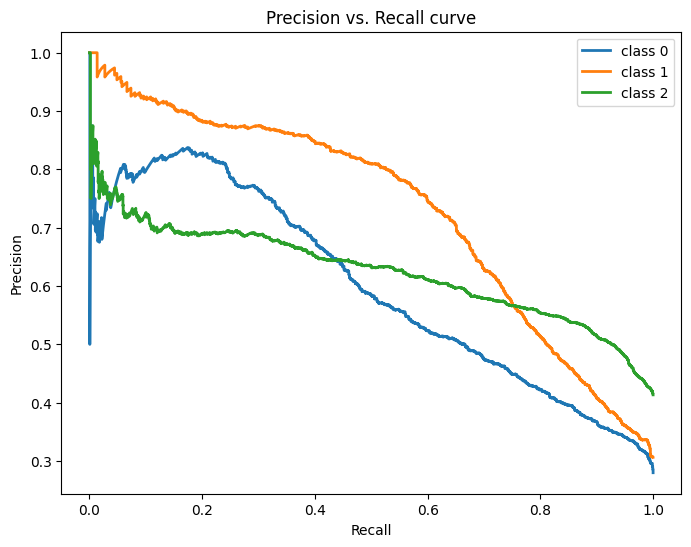

In [35]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Plot all ROC curves
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


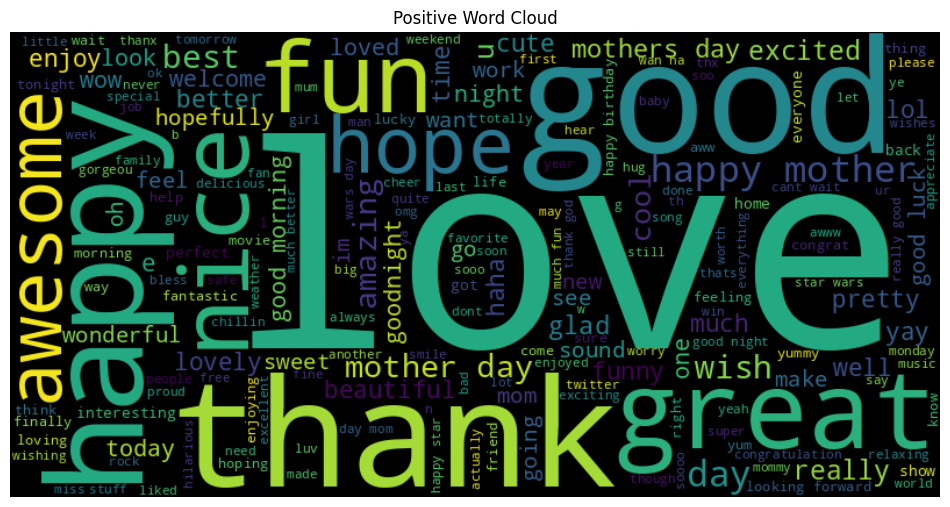

In [39]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
positive_texts = df_train[df_train['sentiment'] == 'positive']['selected_text']
negative_texts = df_train[df_train['sentiment'] == 'negative']['selected_text']
neutral_texts = df_train[df_train['sentiment'] == 'neutral']['selected_text']

# Tokenize and extract words for each sentiment category
positive_words = [word.lower() for text in positive_texts for word in word_tokenize(str(text))]
negative_words = [word.lower() for text in negative_texts for word in word_tokenize(str(text))]
neutral_words = [word.lower() for text in neutral_texts for word in word_tokenize(str(text))]

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
positive_words = [word for word in positive_words if word not in stop_words]
negative_words = [word for word in negative_words if word not in stop_words]
neutral_words = [word for word in neutral_words if word not in stop_words]

def plot_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(words))
    plt.figure(figsize=(12, 8)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_word_cloud(positive_words, 'Positive Word Cloud')

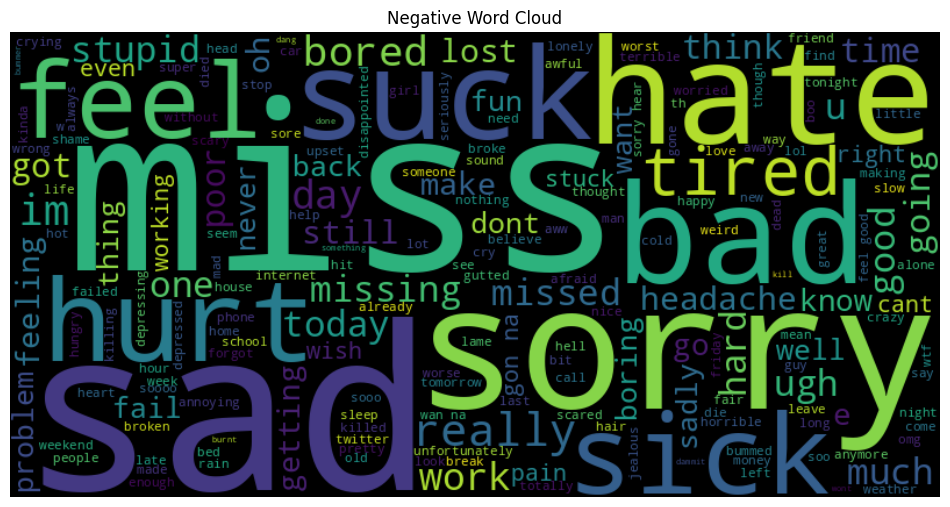

In [40]:
plot_word_cloud(negative_words, 'Negative Word Cloud')

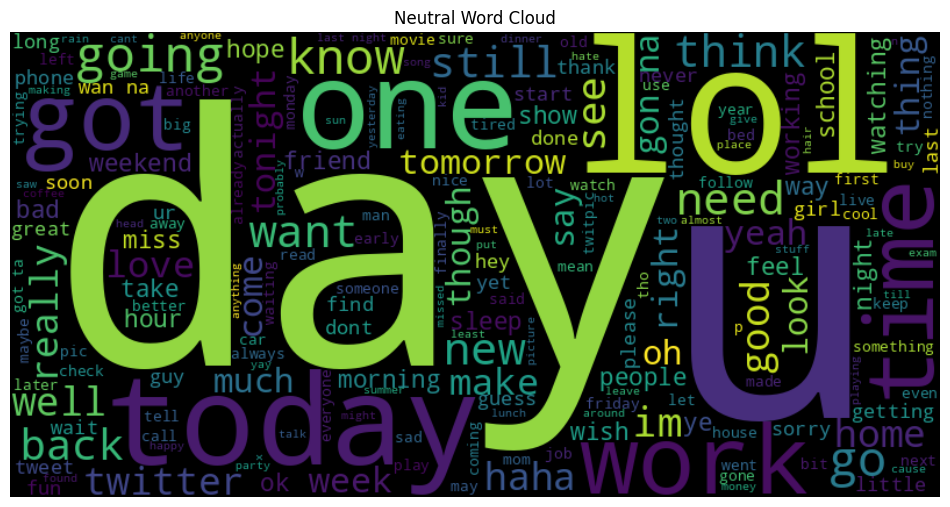

In [41]:
plot_word_cloud(neutral_words, 'Neutral Word Cloud')

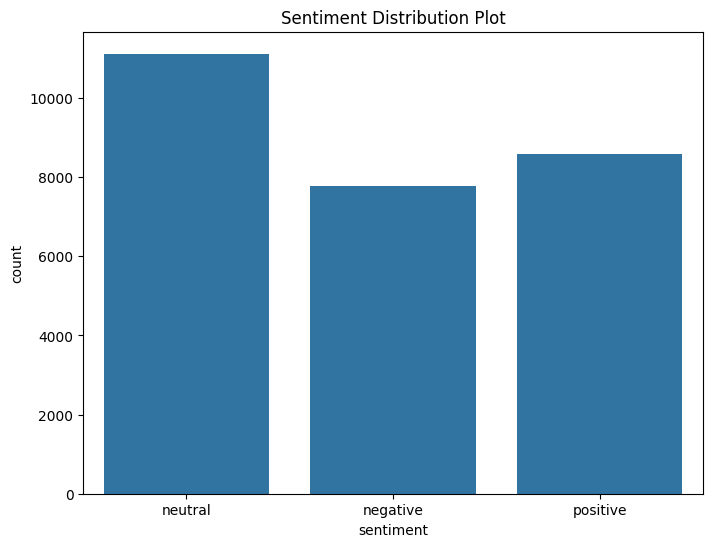

In [42]:
# Sentiment Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_train)
plt.title('Sentiment Distribution Plot')
plt.show()

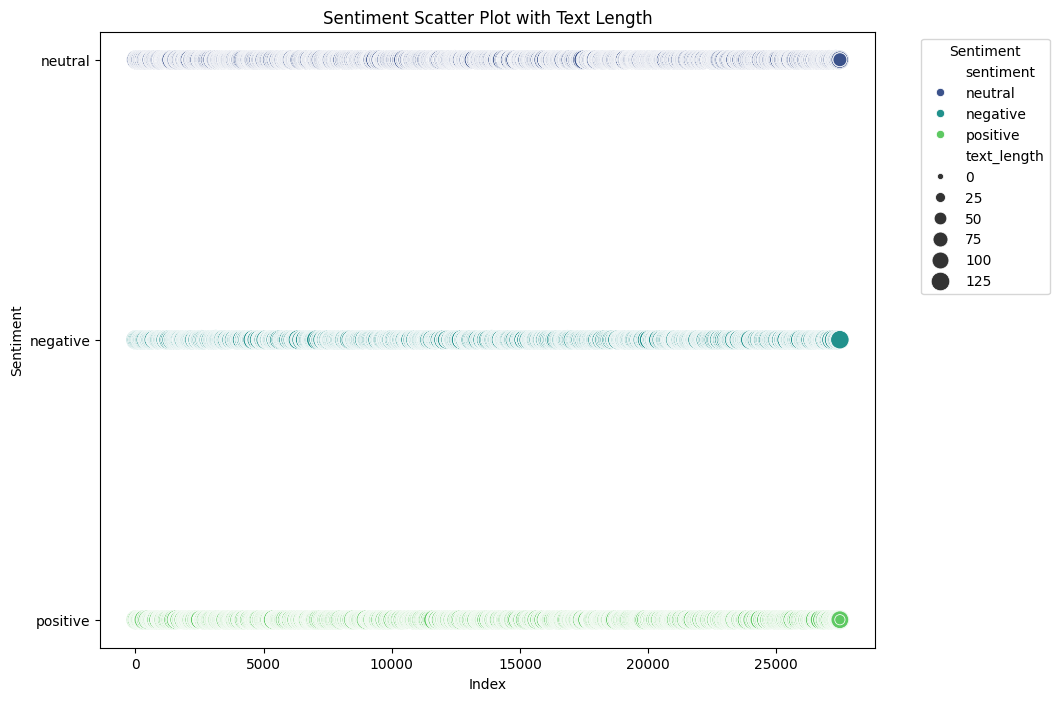

In [59]:
plt.figure(figsize=(10, 8))
df_train['text_length'] = df_train['text'].apply(len)

sns.scatterplot(x=df_train.index, y='sentiment', size='text_length', data=df_train, hue='sentiment', sizes=(20, 200), palette='viridis')
plt.title('Sentiment Scatter Plot with Text Length')
plt.xlabel('Index')
plt.ylabel('Sentiment')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [47]:
model = Model(inputs=input_layer, outputs=[output_layer, attention_out])
prediction, attention_weights = model.predict(X_test_padded)

172/172 [==============================] - 1s 3ms/step


In [48]:
attention_sample = attention_weights[0]

attention_avg = np.mean(attention_sample, axis=0)

# Identify top-k tokens
top_k_indices = np.argsort(attention_avg)[-5:]  # Get indices of top 5 tokens

In [56]:
def highlight_keywords(text_tokens, top_indices):
    highlighted_text = ""
    for idx, token in enumerate(text_tokens):
        if idx in top_indices:
            highlighted_text += "**{}** ".format(token)  # Markdown emphasis
        else:
            highlighted_text += "{} ".format(token)
    return highlighted_text

highlighted_text = highlight_keywords(df_train['tokens'], top_k_indices)
print(highlighted_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
sentiment_lexicon = {
    "positive": positive_words,
    "negative": negative_words,
    "neutral": neutral_words
}

In [53]:
def get_average_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

average_vectors = {
    sentiment: get_average_vector(words, model_w2v) for sentiment, words in sentiment_lexicon.items()
}

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

def classify_text(text, model, average_vectors):
    # Tokenize and average the input text
    words = text.split()
    input_vector = get_average_vector(words, model).reshape(1, -1)

    # Compute cosine similarities and identify the highest similarity
    similarities = {sentiment: cosine_similarity(input_vector, avg_vec.reshape(1, -1))[0][0]
                    for sentiment, avg_vec in average_vectors.items()}

    return max(similarities, key=similarities.get), similarities

text = df_train['text'][0]s
sentiment, scores = classify_text(text, model_w2v, average_vectors)
print(f"Text is classified as {sentiment} with scores: {scores}")

Text is classified as neutral with scores: {'positive': 0.88490885, 'negative': 0.90595144, 'neutral': 0.9148312}
